<a href="https://colab.research.google.com/github/GwiHwan-Go/Detect_SC/blob/main/Data_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Detect_SC_symptoms'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Detect_SC_symptoms


In [ ]:
!apt-get updqte -qq
!apt-get install fonts-nanum* -qq

E: Invalid operation updqte
Selecting previously unselected package fonts-nanum.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
!pip install konlpy
!pip install soynlp
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.9 MB/s 
     |████████████████████████████████| 453 kB 67.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 9.5 MB/s 


In [ ]:
from konlpy.tag import Okt

## 완성된 우리의 TOKENIZER##

def preprocess_tokenizer(sentence) : 

  pos_tagger = Okt()
  # sentence = emoticon_normalize(sentence) 자세한 건 soyNLP 공식문서 참고 https://github.com/lovit/soynlp
  # sentence = repeat_normalize(sentence) 자세한 건 soyNLP 공식문서 참고 https://github.com/lovit/soynlp

  #soynlp tokenizer로 나눠준 후 konlpy Okt postagger로 품사 판별
  return [word[0]
          for word in pos_tagger.pos(' '.join(tokenizer.tokenize(sentence)))
          if word[1] != 'Josa'] # 조사는 분석에서 제외

def save_df(df,name) :

  path = './results' +'/' + name
  df.to_csv(path)
  print(f"저장성공 경로 : {path} ")

In [ ]:
# 결과물 저장 경로
save_dir = "/content/drive/MyDrive/Detect_SC_symptoms/results"
file_name = "refined_full_custom_tokenizer.csv" # tokenized X = refined_full.csv / with Okt tokenizer = refined_full_okt_tokenized.csv
data_path = f"/content/drive/MyDrive/Detect_SC_symptoms/results/{file_name}" 
data = pd.read_csv(data_path, low_memory=False, index_col=0) 
data.date = pd.to_datetime(data.date)
first_id, last_id = data.loc[0,'id'], data.loc[data.shape[0]-1,'id']
first_day, last_day = data.loc[0,'date'], data.loc[data.shape[0]-1,'date']
print("총 기간", first_day, '~', last_day )
print("수집한 게시물 범위 :", first_id, "~", last_id, "\n" \
      "수집된 데이터 크기 :", data.shape[0], "\n수집한 데이터 features :", data.columns)
data.tail()

총 기간 2021-03-03 00:00:00 ~ 2022-10-27 00:00:00
수집한 게시물 범위 : 2 ~ 4445728 
수집된 데이터 크기 : 2470236 
수집한 데이터 features : Index(['id', 'title', 'author', 'date', 'link'], dtype='object')


,id,title,author,date,link
2470231,4445724,나 병신 ...,민애,2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470232,4445725,나고 닉 글 올리 규 싶 읃데,조팡이(118.235),2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470233,4445726,씨발 남자 직원 음식 깔아 주,연우ㅗ(223.62),2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470234,4445727,나도 근데 아이디 두 번 바꿈,.O2,2022-10-27,https://m.dcinside.com/board/depression_new1/4...
2470235,4445728,알바 바보 쉨 ㅋㅋㅋ 나도 차단 해봐라,민애,2022-10-27,https://m.dcinside.com/board/depression_new1/4...


In [ ]:
print(f"중복, NAN 제거 전 데이터 수 = {data.shape}")
data = data.drop_duplicates(['id'])
data = data[data.title.isna()==False]
print(f"중복, NAN 제거 후 데이터 수 = {data.shape}")

중복, NAN 제거 전 데이터 수 = (2470236, 5)
중복, NAN 제거 후 데이터 수 = (2469803, 5)


## 텍스트 데이터는 어떤 정보를 가지고 있을까?

In [ ]:
from scipy import sparse
import pickle
from soynlp.word import pmi as pmi_func
from sklearn.metrics import pairwise_distances
import numpy as np

class Pmi() :

  def __init__(self, words_mat_path, index_list_path) :

    self.mat = sparse.load_npz(mat_save_path)

    with open(index_list_save_path, "rb") as fp:   # Unpickling
      self.idx2vocab = pickle.load(fp)

    self.pmi, self.px, self.py = pmi_func(
                                  self.mat,
                                  min_pmi = 0,
                                  alpha = 0.0,
                                  beta = 0.75
                              )
    self.vocab2idx = {vocab:idx for idx, vocab in enumerate(self.idx2vocab)}

  def np_context_words(self ,target, topk=10) :

    # query = self.vocab2idx[target]

    submatrix = self.pmi[target, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]
    results = np.array(most_relateds)
    # most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return results

  def context_words(self ,target, topk=10) :

    query = self.vocab2idx[target]

    submatrix = self.pmi[query, :].tocsr() # get the row of query
    contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
    pmi_i = submatrix.data

    most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
    most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:topk]
    most_relateds = [[idx, pmi_ij] for idx, pmi_ij in most_relateds]
    # results = np.array(most_relateds)
    most_relateds = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

    return most_relateds

  def similar_words(self, target, topk=10):
      """
      :target: str
          String type query word
      :self.pmi: numpy.ndarray or scipy.sparse.matrix
          self.pmi representation of row
      :self.vocab2idx: dict
          Mapper from str type item to int type index
      :self.idx2vocab: list
          Mapper from int type index to str type item
      :param topk: int
          Maximum number of similar items.
          If set top as negative value, it returns similarity with all words
      Returns
      ----------
      similars : list of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      q = self.vocab2idx.get(target, -1)
      if q == -1:
          return []

      qvec = self.pmi[q].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != q]
      # results = np.array(results)
      results = [(self.idx2vocab[idx], pmi_ij) for idx, pmi_ij in results]

      return results
   
  def np_similar_words(self, target, topk=10):
      """
      :target: str
          String type query word
      :self.pmi: numpy.ndarray or scipy.sparse.matrix
          self.pmi representation of row
      :self.vocab2idx: dict
          Mapper from str type item to int type index
      :self.idx2vocab: list
          Mapper from int type index to str type item
      :param topk: int
          Maximum number of similar items.
          If set top as negative value, it returns similarity with all words
      Returns
      ----------
      similars : list of tuple
          List contains tuples (item, cosine similarity)
          Its length is topk
      """

      # q = self.vocab2idx.get(target, -1)
      # if q == -1:
      #     return []

      qvec = self.pmi[target].reshape(1,-1)
      dist = pairwise_distances(qvec, self.pmi, metric='cosine')[0]
      sim_idxs = dist.argsort()

      if topk > 0:
          sim_idxs = sim_idxs[:topk+1]

      results = [[idx, 1 - dist[idx]] for idx in sim_idxs if idx != q]
      results = np.array(results)

      return results
  
  def idx_to_word(self, indices_list) :
    
    return [self.idx2vocab[word] for index in indices_list]

  def word_to_idx(self, word_list) :

    return [self.vocab2idx[word] for word in word_list]



mat_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/words_sparse_mat.npz"
index_list_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/idx_to_vocabs"
pmi = Pmi(mat_save_path,index_list_save_path)

In [ ]:
for seed in tqdm(seeds) :
  if seed in pmi.vocab2idx :
    for kind in range(2) :
      # contexts = pmi.context_words(seed,topk=40)
      similars = pmi.similar_words(seed,topk=40)
      print(similars)

  0%|          | 0/18 [00:00<?, ?it/s]

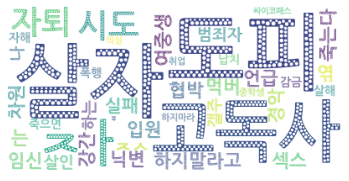

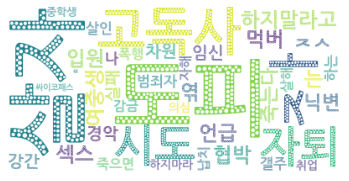

  6%|▌         | 1/18 [00:06<01:54,  6.72s/it]

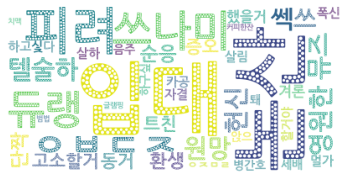

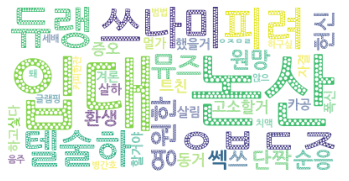

 11%|█         | 2/18 [00:12<01:34,  5.93s/it]

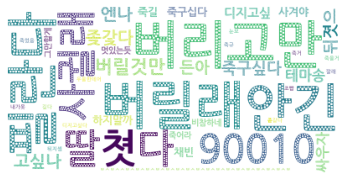

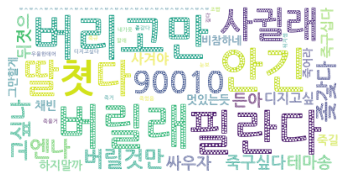

 33%|███▎      | 6/18 [00:18<00:31,  2.63s/it]

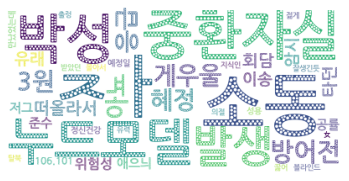

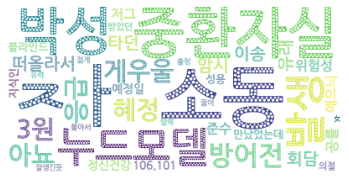

 39%|███▉      | 7/18 [00:23<00:35,  3.20s/it]

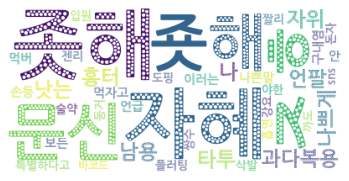

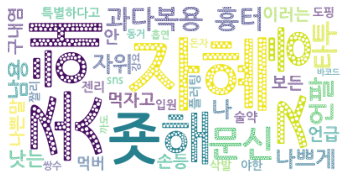

 61%|██████    | 11/18 [00:29<00:15,  2.22s/it]

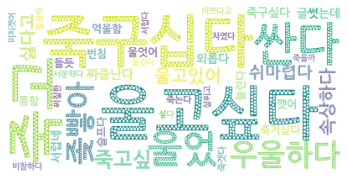

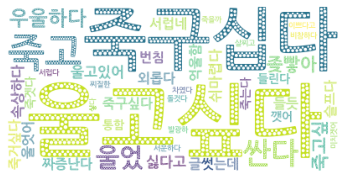

 72%|███████▏  | 13/18 [00:36<00:12,  2.54s/it]

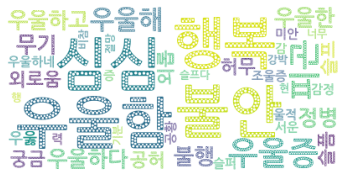

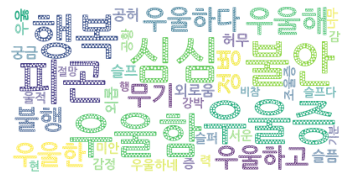

 78%|███████▊  | 14/18 [00:42<00:12,  3.09s/it]

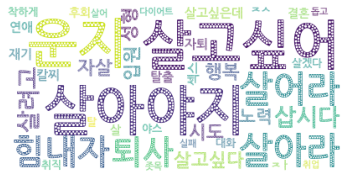

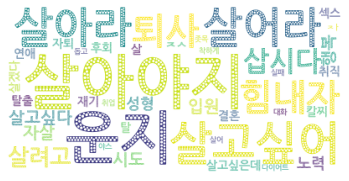

 89%|████████▉ | 16/18 [00:48<00:06,  3.07s/it]

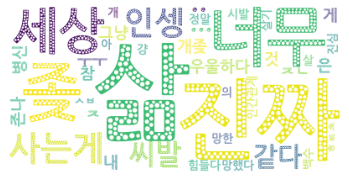

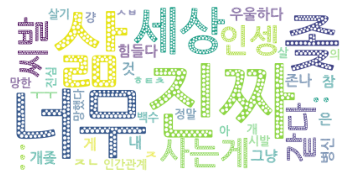

 94%|█████████▍| 17/18 [00:54<00:03,  3.62s/it]

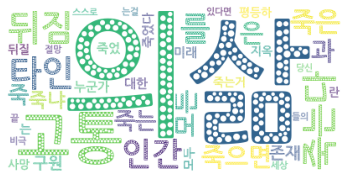

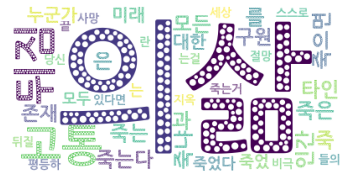

100%|██████████| 18/18 [01:00<00:00,  3.34s/it]


In [ ]:
## SEED 단어들에 대해서 PMI 메트릭스를 통해
## 비슷한 단어들과 같은 맥락 단어들을 추출.

seeds= ['자살','동반','ㄷㅂㅈㅅ','ㅂㄱㅌ','자살계',
        '죽을래','투신','자살쇼','자살각','자해계','자해','자해전시','죽고싶다','우울','ㅈ해','살자',
        '인생','죽음']

import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

print([f for f in sys_font if 'Nanum' in f])
path = '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf' # 위 paths 중 하나로.

for seed in tqdm(seeds) :
  if seed in pmi.vocab2idx :
    for kind in range(2) :
      contexts = pmi.context_words(seed,topk=40)
      similars = pmi.similar_words(seed,topk=40)

      wc_context = WordCloud(font_path=path, relative_scaling=0.1,mode='RGB', prefer_horizontal=1.1,
                background_color='white',collocation_threshold=20).generate_from_frequencies(dict(contexts))
      wc_similar = WordCloud(font_path=path, relative_scaling=0.1,mode='RGB', prefer_horizontal=0.95,
                background_color='white',collocation_threshold=20).generate_from_frequencies(dict(similars))

      plt.figure()
      plt.imshow(wc_context)
      plt.imshow(wc_similar)

      plt.axis('off')
      plt.show()
      wc_context.to_file(f'./images/{seed}_context_wordcloud.jpg')
      wc_similar.to_file(f'./images/{seed}_similar_wordcloud.jpg')

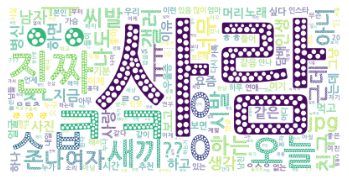

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

path = '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf'
wc = WordCloud(font_path=path, relative_scaling=0.2,
               background_color='white').generate_from_frequencies(all_words)

plt.figure()
plt.imshow(wc)
plt.axis('off')
plt.show()
wc.to_file('./wordcloud.jpg')

### 게시글에서 우울증 지수를 뽑아내보자.

1. PMI 분석된 것을 기준. [PMI란?](!https://github.com/lovit/soynlp/blob/master/tutorials/pmi_usage.ipynb)
2. Seeds 단어들(자살과 관련된 핵심적인 단어들)로 시작
3. 관련 단어 상위 10위, 가까운 것부터 배수 배정
4. gradient를 곱해서 다시 PMI 분석. -> 정해진 기준까지.
5. 다 더한다.

## Params 화 해서 heuristic 하게 조정해보자.

--> Depression Graph Note 에서 해결중

In [ ]:
from scipy import sparse
from scipy.sparse import csr_matrix
import networkx as nx

context_network_path='/content/drive/MyDrive/Detect_SC_symptoms/models/context_graph_full_final.npz'
context_sparse_matrix = sparse.load_npz(context_network_path)
CG=nx.from_scipy_sparse_matrix(context_sparse_matrix)

In [ ]:
# Weight 분포 보기
import pandas as pd 
def show_w_e_dist(G) :
  weights = [wt for (u, v, wt) in G.edges.data('weight')]
  degrees = [G.degree(node) for node in G.nodes]
  return pd.DataFrame(degrees), pd.DataFrame(weights)

ds, ws = show_w_e_dist(CG)
ds.describe()

,0
count,49771.000000
mean,38.234193
std,29.574246
min,0.000000
25%,30.000000
50%,30.000000
75%,33.000000
max,621.000000


In [ ]:
ws.describe()

,0
count,951477.000000
mean,1.399753
std,0.300596
min,0.840366
25%,1.198427
50%,1.355310
75%,1.559932
max,3.980281


In [ ]:
## idx -> word
relabel_nodes = {idx : word for idx, word in enumerate(pmi.idx2vocab)}
CG = nx.relabel_nodes(CG, relabel_nodes)

In [ ]:
## filter node which has less edges.
minimum_edges = 33
CG_fnodes = nx.subgraph_view(CG, 
                          filter_node=lambda x : CG.degree[x]>=minimum_edges) 
print(f"n(nodes) : {CG.number_of_nodes()} ---> {CG_fnodes.number_of_nodes()}")

n(nodes) : 49771 ---> 12866


In [ ]:
a,b = show_w_e_dist(CG_fnodes)
b

,0
0,1.079323
1,0.941147
2,0.846484
3,0.904055
4,0.857961
...,...
43403,2.005453
43404,1.725588
43405,2.009807
43406,1.948805


In [ ]:
b.describe()

,0
count,43408.000000
mean,1.340689
std,0.220804
min,0.840439
25%,1.218602
50%,1.337664
75%,1.453997
max,2.757303


In [ ]:
## filter edges which has less weights.

minimum_weight = 1.337664

def filter_edge(n1, n2):
    return CG_fnodes[n1][n2]['weight'] > minimum_weight

CG_fnodes_fedges = nx.subgraph_view(CG_fnodes, 
                                    filter_node = lambda x : True,
                                    filter_edge=filter_edge) 
print(f"n(edges) : {CG_fnodes.number_of_edges()} ---> {CG_fnodes_fedges.number_of_edges()}")


n(edges) : 43408 ---> 21704


In [ ]:
page_rank_results = nx.pagerank(CG_fnodes_fedges)

In [ ]:
{key:rank for key,rank in sorted(page_rank_results.items(),key=lambda x:x[1],reverse=True) if len(key) > 1}

{'천억': 0.0005009175580624663,
 '빌려서': 0.0004359816172911272,
 '버버리': 0.00043353061779738574,
 '빨강': 0.00043051944123072424,
 '는다고': 0.00042585852974013824,
 '기합': 0.0004252908707213913,
 '짜랑': 0.0004141021330838735,
 '기는거': 0.00041157474225412806,
 '래시': 0.00039774543603801366,
 '가온': 0.000395068130806338,
 '당하지': 0.00039301674345313206,
 '더어': 0.0003876691627458677,
 'mma': 0.00038554849740437896,
 '낮밤': 0.00038529519597959525,
 '심어': 0.0003806435301150356,
 '깜방': 0.00037905641032619675,
 '청구': 0.00036983219645014533,
 '됐을까': 0.00036873977854248925,
 '생명체': 0.0003677039247596386,
 '대작': 0.0003663583062005086,
 '뜨리': 0.00036317250466022933,
 '른거': 0.0003605880218849385,
 'ㄴㄴㄴ': 0.00036054729156322047,
 '상반기': 0.00035774337532455897,
 '피안': 0.00035727841365889256,
 '베게': 0.00035599564323500943,
 '소시': 0.0003542980059244498,
 '진술': 0.0003537781953393691,
 '유니클로': 0.0003474603375701946,
 '는나': 0.00034501819708459755,
 '체다': 0.0003430475679204944,
 'ㅅㅂㅋ': 0.0003422404288799182,
 '붕알': 0.00

In [ ]:
# saving graph created above in gexf format
nx.write_gexf(CG_fnodes_fedges, "./models/context_graph_final.gexf") 

In [ ]:
CG_fnodes_fedges.edges('피겠')

EdgeDataView([('피겠', '먹겠'), ('피겠', '보겠'), ('피겠', '버티겠'), ('피겠', '폈'), ('피겠', '끊겠'), ('피겠', '듣겠'), ('피겠', '피겟'), ('피겠', '봐주겠'), ('피겠', '머르겟'), ('피겠', '사겠'), ('피겠', '싸겠'), ('피겠', '피게'), ('피겠', '까겠'), ('피겠', '폇어')])

Text(0.5, 1.0, '쪼랩 프렌즈')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47017 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51900 missing from current font.
  font.set_

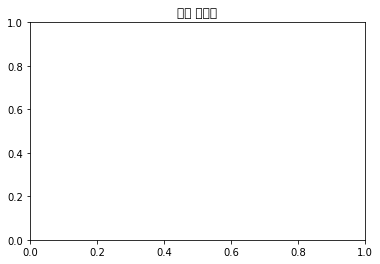

In [ ]:
import matplotlib.pyplot as plt
path = '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf'

plt.rc('font', family=path)
plt.title('쪼랩 프렌즈')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49332 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text

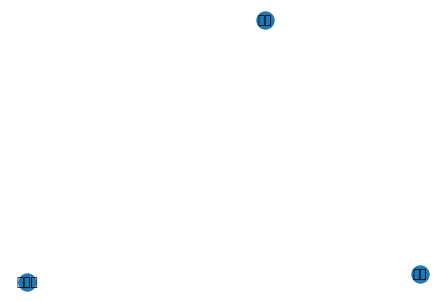

In [ ]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf'

keyword = '자살'
keyword_CG = nx.subgraph_view(CG_fnodes_fedges, 
                                    filter_node = lambda x : keyword in [e for s,e in CG_fnodes_fedges.edges(x)]) 
nx.draw(keyword_CG, with_labels=True)

In [ ]:
keyword_CG.nodes

NodeView(('도피', '살자', '고독사'))

In [ ]:
nx.draw(keyword_CG, with_labels=True)

### 게시물들은 __언제__, 얼마나 작성되었을까?
**Code 정리되지 않음**

In [ ]:
# 분석에 앞서, 멀티 인덱스 DF 생성

df = data.set_index('id').copy()
df = df.set_index(['date','author'])
group_by_title_sum = df.groupby(level=['date', 'author']).sum()
group_by_count = df.groupby(level=['date', 'author']).count()
group_by_title_sum['length'] = group_by_count.title.str.len()
group_by_title_sum

In [ ]:
# 달, 요일 별로 게시물 분포 보기

# 1. data.date.dt.month
# 2. data.date.dt.day_names()

df = data.copy()
df.date = data.date.dt.month
# df = df.loc[:,['id','date','author']].groupby(by='date').groupby(by='author').count()
# grouped_by_date_count = df.sort_values(by='date')
# grouped_by_date_count

In [ ]:
grp = data[data.title.isna()==False].groupby('date').agg(title=('title', ' '.join)).reset_index()
grp

In [ ]:
def high_freq_words(counter) :
  return ' '.join([word for word,count in counter.most_common(200)])

In [ ]:
from collections import Counter
temp = grp.title.apply(lambda x : Counter( i for i in x.split(' ') if len(i)>1 ))
all_words = temp.sum()
# fine = temp.apply(high_freq_words)
# fine

0      ㅋㅋ 갤러 사람 .. 새끼 ?? 여자 존나 념글 친구 진짜 아니 나도 근데 병신 하...
1      ㅋㅋ 사람 .. 진짜 갤러 ... 새끼 ㅅㅂ 오늘 하는 잠깐 지켜주세요 너무 아니 ...
2      사람 .. ㅋㅋ 존나 ... 새끼 갤러 진짜 하는 오늘 여자 정숙 씨발 아니 너무 ...
3      ㅋㅋ 사람 .. 진짜 새끼 존나 오늘 ㅅㅂ 하는 씨발 클럽 남자 ... 여자 친구 ...
4      사람 .. ㅋㅋ 존나 ㅅㅂ 진짜 새끼 오늘 너무 ... 친구 하는 아니 근데 갤러 ...
                             ...                        
574    진짜 이해 사람 ㅋㅋ ㅇㅅㅇ ㅇㅇ .. 씨발 새끼 ㅅㅂ 존나 해서 하는 ... ㅜㅜ...
575    사람 진짜 ㅅㅂ ㅋㅋ .. ㅇㅅㅇ ㅇㅇ 씨발 새끼 존나 여자 하는 ... 너무 ㅜㅜ...
576    사람 진짜 ㅋㅋ .. 새끼 ㅇㅅㅇ ㅅㅂ ㅇㅇ 존나 ㅜㅜ 오늘 카오 씨발 ... 하는...
577    .. 사람 ㅋㅋ ㅅㅂ 진짜 ... ㅜㅜ 새끼 ㅇㅇ 씨발 오늘 존나 ㅇㅅㅇ 너무 여자...
578    .. ㅋㅋ 진짜 사람 ㅇㅇ ㅅㅂ 씨발 ... 새끼 이델 오늘 근데 시발 하는 사진 ...
Name: title, Length: 579, dtype: object

In [ ]:
pd.DataFrame(all_words.most_common(200),columns=['word','freq']).to_csv('word_freq.csv')

In [ ]:
pd.DataFrame.from_dict(temp)

,title
0,"{'먹는': 7, 'ㅎㅇ': 6, '지배': 2, '자인': 1, '나야': 2, ..."
1,"{'솔직히': 19, '소득': 1, '돈버': 3, '사람': 147, '들은':..."
2,"{'우리': 27, '아빠': 13, '사쟈': 1, '슬리퍼': 1, '신고': ..."
3,"{'누워서': 4, '깜빡': 2, '내일': 15, '부천': 2, '을사': 1..."
4,"{'대줄': 1, '업냐': 2, '까는': 2, '념글': 5, '가서': 16,..."
...,...
574,"{'아니': 69, '파란약': 1, '발랏': 1, '는데': 37, '베베': ..."
575,"{'진짜': 198, '무시': 7, '하자': 16, '지하드': 78, 'ㅈㄴ'..."
576,"{'저격': 2, 'ㅈㄴ': 55, '당했는데': 5, '접읆가': 1, '사펑':..."
577,"{'돔베': 3, '라서': 6, '아니라': 11, '현실': 14, '머노': ..."


In [ ]:
sorted(temp[0], key=lambda x: x[0])

['!',
 '!!!',
 '!!!!!!',
 '!!',
 '!!!!!',
 '"',
 '#소통해요',
 '$_<',
 '%',
 "'",
 '(',
 '(?)',
 ')',
 ')))',
 ').',
 '**',
 '*',
 '***',
 '+*******',
 ',.',
 ',',
 ',;',
 ',,',
 ',,,',
 '-~~~',
 '-',
 '.',
 '....?!',
 '..',
 '....',
 '.?',
 '.....',
 '...',
 '..?',
 '......',
 '..;',
 '/',
 '021',
 '03',
 '04',
 '0만원',
 '00만원',
 '02',
 '15',
 '1',
 '100',
 '10',
 '123',
 '129',
 '12',
 '1년',
 '184',
 '170',
 '18~2021년',
 '15년',
 '1~2',
 '1등',
 '16',
 '10만원',
 '150',
 '12시간',
 '1회',
 '1일',
 '18년',
 '1시',
 '20',
 '2',
 '23',
 '2년',
 '26',
 '2분',
 '21년',
 '22',
 '2일',
 '200',
 '31',
 '30',
 '3',
 '34',
 '30분',
 '37',
 '3월',
 '3분',
 '3천원',
 '3일',
 '300',
 '39.7',
 '38',
 '3천',
 '4시',
 '4억',
 '40',
 '42',
 '45.33',
 '4',
 '445',
 '49',
 '456',
 '50',
 '5시',
 '51',
 '5',
 '5분',
 '5일',
 '5년',
 '5만원',
 '50만원',
 '518',
 '6',
 '6년',
 '67',
 '6.25',
 '6일',
 '7시',
 '7',
 '8월',
 '8',
 '80',
 '9',
 '9105',
 ':',
 ';',
 ';;',
 '<<',
 '<',
 '<-',
 '=',
 '?',
 '????',
 '?????',
 '??',
 '????????',
 '?????

In [ ]:
temp = data.reset_index().loc[:,['date','title']].groupby(by='date').sum()
temp

,title
date,
2021-03-03,첫 글 은 내 먹는 다ㅎㅇ울 갤 의 지배 자인 나야하아 잇 사랑 해ㅅㅂ 내 일 빠 ...
2021-03-04,솔직히 블 소득 돈버 사람 들은 양심 이 있어 야 된다 생각 함어떻게 끝날까 나존나...
2021-03-05,우리 아빠 누 군 줄 알 ? 천 것 들악 사쟈 .슬리퍼 신고 기차 타 되지 ??부랄...
2021-03-06,누워서 눈 깜빡 깜빡내일 부천 밥 먹 을사 람이 거 맛있 어보 ? 진짜 ... 진심...
2021-03-07,대줄 년 업냐나 까는 글 념글 가서 슬픈 데 개추 함키 170 눈길 3 센치 이상 ...
...,...
2022-10-23,아니 파란약 발랏 는데 ? 베베우울할 때 머 하냐고 ㅜㅜㅜ 수 ㅜㅜㅜㅜㅜㅜㅜㅜ 씨발...
2022-10-24,진짜 무시 하자 지하드 하 ㅈㄴ 힘드 네 안 그래도 힘든데하 나 남자 칭구 있었으면...
2022-10-25,저격 ㅈㄴ 당했는데 울 갤 접읆가사펑 애니 보지마라못 생겨서 아무 말을안건 다 ㅜㅜ...


In [ ]:
temp

date
2021-03-03    [date, title]
2021-03-04    [date, title]
2021-03-05    [date, title]
2021-03-06    [date, title]
2021-03-07    [date, title]
                  ...      
2022-10-23    [date, title]
2022-10-24    [date, title]
2022-10-25    [date, title]
2022-10-26    [date, title]
2022-10-27    [date, title]
Length: 579, dtype: object

In [ ]:
from collections import Counter
temp.iloc[:5,:].title.apply(x : Counter())

,title
date,
2021-03-03,첫 글 은 내 먹는 다ㅎㅇ울 갤 의 지배 자인 나야하아 잇 사랑 해ㅅㅂ 내 일 빠 ...
2021-03-04,솔직히 블 소득 돈버 사람 들은 양심 이 있어 야 된다 생각 함어떻게 끝날까 나존나...
2021-03-05,우리 아빠 누 군 줄 알 ? 천 것 들악 사쟈 .슬리퍼 신고 기차 타 되지 ??부랄...
2021-03-06,누워서 눈 깜빡 깜빡내일 부천 밥 먹 을사 람이 거 맛있 어보 ? 진짜 ... 진심...
2021-03-07,대줄 년 업냐나 까는 글 념글 가서 슬픈 데 개추 함키 170 눈길 3 센치 이상 ...
...,...
2022-10-23,아니 파란약 발랏 는데 ? 베베우울할 때 머 하냐고 ㅜㅜㅜ 수 ㅜㅜㅜㅜㅜㅜㅜㅜ 씨발...
2022-10-24,진짜 무시 하자 지하드 하 ㅈㄴ 힘드 네 안 그래도 힘든데하 나 남자 칭구 있었으면...
2022-10-25,저격 ㅈㄴ 당했는데 울 갤 접읆가사펑 애니 보지마라못 생겨서 아무 말을안건 다 ㅜㅜ...


### 게시물들은 __누가__, 얼마나 작성했을까?

In [ ]:
df = data.set_index('id').copy()
df = df.set_index(['date','author'])
group_by = df.groupby(level=['date', 'author']).count()
group_by

In [ ]:
grouped_by_author_count

,id
author,
젠지우승(121.131),1
일침남(106.101),1
일이삼(121.139),1
일엉(118.235),1
김창수(211.215),1
...,...
김경직,32212
루시드,36911
제이통,43441


In [ ]:

temp

,author,title,id
0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5
1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49
2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1
3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17
4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4
...,...,...,...
32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1
32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186
32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16
32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3


In [ ]:
grouped_by_author = pd.read_csv(save_dir+'/'+'contents_by_author.csv')
# temp = pd.merge(left = temp , right = data.loc[:,['id','author']].groupby(by='author').count(), how = "inner", on = "author")
# temp.rename(columns = {'id':'post_count'},inplace=True)
# grouped_by_author['whole_length'] = grouped_by_author.title.str.len()
grouped_by_author


,Unnamed: 0,author,title,post_count,whole_length
0,0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5,112
1,1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49,477
2,2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1,14
3,3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17,227
4,4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4,38
...,...,...,...,...,...
32945,32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1,22
32946,32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186,2331
32947,32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16,208
32948,32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3,24


In [ ]:
from tqdm import tqdm
tqdm.pandas()
grouped_by_author['diversity'] = grouped_by_author.title.progress_apply(lambda x : len(set(tokenizer(x))) / len(tokenizer(x)))

100%|██████████| 32950/32950 [01:50<00:00, 297.94it/s]


In [ ]:
grouped_by_author

,Unnamed: 0,author,title,post_count,whole_length,diversity
0,0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5,112,0.970588
1,1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49,477,0.946565
2,2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1,14,1.000000
3,3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17,227,0.986301
4,4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4,38,1.000000
...,...,...,...,...,...,...
32945,32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1,22,1.000000
32946,32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186,2331,0.773676
32947,32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16,208,0.935484
32948,32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3,24,1.000000


In [ ]:
## title -> tokenized 된 걸로 바꾸고 -> 우울증 지수 계산 


,author,title,post_count,whole_length
0,,솔직히 21살이나 39살이나 겉모습으론 구분안되는듯? ㅎㅎ배꼽주의) 충동구매를 많이...,5,112
1,..(182.213),"..다녀왔습니다룸빵녀 젖 주무르기걔 어디갔냐룸빵하면 ,, 그갤러보구싶다 ㅠㅠㅠㅠㅠ그...",49,477
2,.민초죠아(61.75),속보) 거꾸로 돼지바 출시,1,14
3,T-REX(112.72),천애협로 재밌네신마경천기도 재밌더라아침 댓바람부터 공차던 때가 그립다톰하디 레전드 ...,17,227
4,T-REX(223.33),외자 이름 뭔가 멋있음비와이 처럼 랩하고싶다대학살을 준비군사의 생사필,4,38
...,...,...,...,...
32945,盧아(49.172),제가 盧아라는 사실을 잊지말아주세요...,1,22
32946,＃아이묭,갤러리 불판 갈았네요.커터칼 팔목 위에 세우기 하실 분.일어났어요.배고파요.지금 듣...,186,2331
32947,（＾ω＾）(1.229),다 아는 사람들이구먼개이들아 야식 ㄱㄱ ㄴㄴ?우울증 완치함 ㅁㅌㅊ?친구한테 ㅆㅎㅌㅊ...,16,208
32948,（＾ω＾）(118.235),나 곧 생일임타투갤이노ㅋㅋ공앱 존나 갤갤거림,3,24


In [ ]:

grouped_by_author.to_csv(save_dir+'/'+'contents_by_author.csv')

In [ ]:
from soynlp.vectorizer import sent_to_word_contexts_matrix
from scipy import sparse
import pickle
from soynlp.word import pmi as pmi_func

okt = Okt() ## 미리 분석한 정보 로드
mat_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/words_sparse_mat.npz"
index_list_save_path = "/content/drive/MyDrive/Detect_SC_symptoms/models/idx_to_vocabs"

x = sparse.load_npz(mat_save_path)
with open(index_list_save_path, "rb") as fp:   # Unpickling
  idx2vocab = pickle.load(fp)

pmi, px, py = pmi_func(
    x,
    min_pmi = 0,
    alpha = 0.0,
    beta = 0.75
)

vocab2idx = {vocab:idx for idx, vocab in enumerate(idx2vocab)}
query = vocab2idx['살고싶다']

submatrix = pmi[query,:].tocsr() # get the row of query
contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
pmi_i = submatrix.data

most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:10]
most_relateds = [(idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

from pprint import pprint
pprint(most_relateds)

[('말안하고', 5.539395551806139),
 ('받으며', 5.453687463545265),
 ('베어그릴스', 5.371115126218525),
 ('박영', 5.2524471223073546),
 ('키우면서', 5.2524471223073546),
 ('배당금', 5.19948394689689),
 ('성공해서', 5.182629305007846),
 ('대강', 5.140154545808996),
 ('가혹하', 5.134225414154668),
 ('하쿠', 5.118760948752615)]


In [ ]:
##SoyNLP 훈련 및 저장 코드
from soynlp.word import WordExtractor

word_extractor = WordExtractor()
word_extractor.train(data[data.title.isna()==False].title)
word_score_table = word_extractor.extract()

model_fname="/content/drive/MyDrive/Detect_SC_symptoms/models" + "/" + "soy_wordExtractor_full.model"
word_extractor.save(model_fname)

training was done. used memory 6.691 Gb
all cohesion probabilities was computed. # words = 480337
all branching entropies was computed # words = 523918
all accessor variety was computed # words = 523918


In [ ]:
import math
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

## Word_Extractor param 설정 및 로드
word_extractor = WordExtractor(min_frequency=10,
                               min_cohesion_forward=5.0,
                               min_right_branching_entropy=0.0)
word_extractor.load(model_fname)

## Cohesion 과 Entropy 계산해서 tokenizer 생성
scores = word_extractor.word_scores()
scores = {key : (scores[key].cohesion_forward * math.exp(scores[key].right_branching_entropy)) \
          for key in scores.keys()}

## tokenizer 생성
tokenizer = LTokenizer(scores=scores)

all cohesion probabilities was computed. # words = 480337
all branching entropies was computed # words = 523918
all accessor variety was computed # words = 523918


In [ ]:
## SoyNLP 사용 예 -> SoyNLP(tokenizer) -> okt pos tagger -> 불용어 제거
from konlpy.tag import Okt
from soynlp.normalizer import *

def preprocess_tokenizer(sentence) : 

  pos_tagger = Okt()
  # sentence = emoticon_normalize(sentence)
  # sentence = repeat_normalize(sentence)

  #soynlp tokenizer로 나눠준 후 konlpy Okt postagger로 품사 판별
  return [word[0]
          for word in pos_tagger.pos(' '.join(tokenizer.tokenize(sentence)))
          if word[1] != 'Josa'] # 조사는 분석에서 제외


# preprocess(tokenizer, sent)
for sent in data.title[-5:] :
  print('before :', sent)
  # print('after :', okt.morphs(sent))
  print(preprocess_tokenizer(sent))

before : 나 병신인가...
['나', '병신', '...']
before : 나고닉으로글올리규싶읃데
['나고', '닉', '글', '올리', '규', '싶', '읃데']
before : 씨발 남자직원이 음식 깔아주니까 
['씨발', '남자', '직원', '음식', '깔아', '주']
before : 나도근데아이디두번바꿈
['나도', '근데', '아이디', '두', '번', '바꿈']
before : 알바 바보 쉨ㅋㅋㅋ 나도 차단해봐라
['알바', '바보', '쉨', 'ㅋㅋㅋ', '나도', '차단', '해봐라']


## PMI 분석


단어들 간의 연관관계를 분석해서 자살 관련 정보 파악에 도움이 되는 __다른 단어__들은 무엇이 있는 지 알아보자.

참고 : [SoyNLP 공식 문서](!https://github.com/lovit/soynlp#vectorizer)

In [ ]:
from soynlp.vectorizer import sent_to_word_contexts_matrix

x, idx2vocab = sent_to_word_contexts_matrix(
    data.title,
    windows=3,
    min_tf=10,
    tokenizer=preprocess_tokenizer, # (default) lambda x:x.split(),
    dynamic_weight=False,
    verbose=True
)

from soynlp.word import pmi

pmi_dok = pmi(
    x,
    min_pmi=0,
    alpha=0.0001,
    verbose=True
)

Create (word, contexts) matrix
  - counting word frequency from 1175000 sents, mem=5.404 Gb

AttributeError: ignored

# 방금 만든 거 무조건 저장해야함.....! 2시간 걸림

In [ ]:
vocab2idx = {vocab:idx for idx, vocab in enumerate(idx2vocab)}
query = vocab2idx['아이오아이']

submatrix = pmi[query,:].tocsr() # get the row of query
contexts = submatrix.nonzero()[1] # nonzero() return (rows, columns)
pmi_i = submatrix.data

most_relateds = [(idx, pmi_ij) for idx, pmi_ij in zip(contexts, pmi_i)]
most_relateds = sorted(most_relateds, key=lambda x:-x[1])[:10]
most_relateds = [(idx2vocab[idx], pmi_ij) for idx, pmi_ij in most_relateds]

from pprint import pprint
pprint(most_relateds)

In [ ]:
from soynlp.utils import most_similar

most_similar('아이오아이', pmi, vocab2idx, idx2vocab)

'ㅋㅋ쿠ㅜㅜ'

In [ ]:
from soynlp.postagger import Dictionary
from soynlp.postagger import LRTemplateMatcher
from soynlp.postagger import LREvaluator
from soynlp.postagger import SimpleTagger
from soynlp.postagger import UnknowLRPostprocessor

dictionary = Dictionary(pos_dict)
generator = LRTemplateMatcher(dictionary)    
evaluator = LREvaluator()
postprocessor = UnknowLRPostprocessor()
tagger = SimpleTagger(generator, evaluator, postprocessor)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ds',
 '_scores',
 'tokenize']

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.histogram(df, x="total_bill")
fig.show()